In [2]:
import os
import tarfile
import urllib
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

## Importing the data

**MNIST dataset**
- A set of 70,000 small images of digits handwritten by high school students and employees of the US Census Bureau. 
- Each image is labeled with the digit it represents.

In [3]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [4]:
X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

In [5]:
y.shape

(70000,)

#### Analysis of shape
- 70,000 images, and each image has 784 features. 
- This is because each image is 28 × 28 pixels 
- Each feature simply represents one pixel’s intensity, from 0 (white) to 255 (black). 


In [6]:
y = y.astype(np.uint8)

## Spliting data to training and test set

- Training 1st 60000 images = **:60000**
- Test set last 10000 images = **60000:**

In [7]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## Training a clasifier
### Binary Classifier

### Stochastic Gradient Descent (SGD) classifier
Using 1 value first

In [9]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [10]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [11]:
some_digit = X.loc[0]

sgd_clf.predict([some_digit])

D:\Courses\machine_learning\machine_learning\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([ True])

## Performance measure

### 1. Cross-Validation 

In [12]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

* K-fold cross-validation means splitting the training set into K folds (in this case, three)
* then making predictions and evaluating them on each fold using a model trained on the remaining folds

- Model has a 95% accuraccy
- Let's classify all the images in the "not-5" class to be sure

In [13]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)
    
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

- 90% accuracy 

### 2. Confusion matrix

In [14]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [15]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

In [16]:
tp = 3530
fp = 687
fn = 1891

precision = tp/(tp+fp)
recall = tp/(tp+fn)

def percentage(value):
    dec = value*100
    ans = round(dec, 2)
    return ans

pr = percentage(precision)
re = percentage(recall)

print("Precision of classifier: ", pr,"%", "\nTrue positive rate", re, "%")

Precision of classifier:  83.71 % 
True positive rate 65.12 %


In [17]:
from sklearn.metrics import precision_score, recall_score

prec = precision_score(y_train_5, y_train_pred)
rec = recall_score(y_train_5, y_train_pred)

pr = percentage(prec)
re = percentage(rec)
print("Precision of classifier: ", pr,"%", "\nTrue positive rate", re, "%")

Precision of classifier:  83.71 % 
True positive rate 65.12 %


#### Analysis
* Claims an image represents a 5, it is correct only **83.71%** of the time. (**Precision**)
* Only detects **65.12%** of the 5s. (**Sensitivity**)

#### Harmonic mean / F1 score

In [18]:
f1 = 2/(1/prec + 1/rec)

p = percentage(f1)
print("F1 score: ", p, "%")

F1 score:  73.25 %


In [19]:
from sklearn.metrics import f1_score
f1 = f1_score(y_train_5, y_train_pred)

p = percentage(f1)
print("F1 score: ", p, "%")

F1 score:  73.25 %


### Prediction/Recall trade off
#### Deciding a threshold using Precision/Recall curve

In [20]:
"""GETING THE SCORE FOR EACH INSTANCE"""

y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

In [21]:
"""GET PRECISION & RECALL FOR ALL POSSIBLE THRESHOLD"""

from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

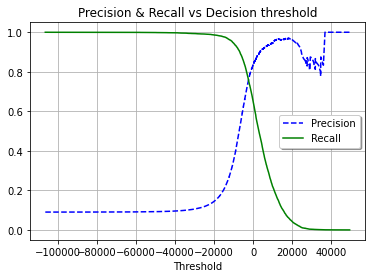

In [22]:
"""PLOTTING PRECISION & RECALL AGAINST THRESHOLD"""

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    
    plt.xlabel("Threshold")
    plt.title("Precision & Recall vs Decision threshold")
    plt.legend(shadow=True)
    plt.grid()
    

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

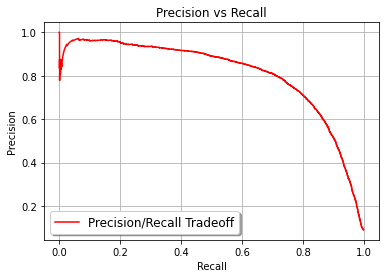

In [23]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls[:-1], precisions[:-1], "r-", label="Precision/Recall Tradeoff")
    
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision vs Recall")
    plt.legend(loc="lower left", shadow=True, fontsize="large")
    plt.grid()
    

plot_precision_vs_recall(precisions, recalls)
plt.show()

#### Analysis
* Precision fall rapidly at 80% recall
* Best threshold is preferable below 80% recall

### Selecting the threshold depending on precision/recall needs

In [24]:
"""90% PRECISION"""

threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
threshold_90_precision

3370.019499143958

In [25]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

pre = precision_score(y_train_5, y_train_pred_90)

pr = percentage(pre)
print("Precision of classifier: ", pr,"%")

Precision of classifier:  90.0 %


In [26]:
rec = recall_score(y_train_5, y_train_pred_90)

re = percentage(rec)
print("Recall of classifier: ", re,"%")

Recall of classifier:  48.0 %


#### Deciding a threshold using ROC Curve

In [27]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

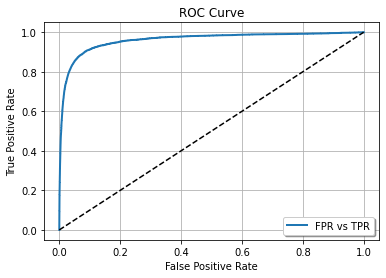

In [28]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label="FPR vs TPR")
    plt.plot([0, 1], [0, 1], 'k--') # Dashed diagonal
    
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc="best", shadow=True, fontsize="medium")
    plt.grid()

plot_roc_curve(fpr, tpr)
plt.show()

In [29]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9604938554008616

## RandomForestClassifier

In [31]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

In [32]:
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

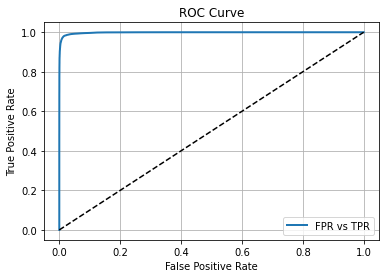

In [34]:
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

### Comparing SGDClassifier to RandomForestClassifier’s ROC curve

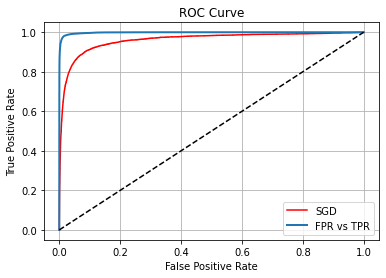

In [38]:
plt.plot(fpr, tpr, "r", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

#### Analysis:
* The **RandomForestClassifier’s** looks much better than the **SGDClassifier’s**
    * As it comes much closer to the top-left corner.
    * In turn will have a higher **AUC SCORE**

In [58]:
auc = roc_auc_score(y_train_5, y_scores_forest)

au = percentage(auc)
print("AUC of classifier: ", au,"%")

AUC of classifier:  99.83 %


In [56]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)

pre = precision_score(y_train_5, y_train_pred_forest)

pr = percentage(pre)
print("Precision of classifier: ", pr,"%")

Precision of classifier:  99.05 %


In [57]:
rec = recall_score(y_train_5, y_train_pred_forest)

re = percentage(rec)
print("Recall of classifier: ", re,"%")

Recall of classifier:  86.63 %


#### Scores:
* **AUC score** = 99.83%
* **Precision** = 99.05%
* **Recall** = 86.63%

### Multiclass Classification
- **Binary classifiers** distinguish between two classes
- **multiclass classifiers** (**multinomial classifiers**) can distinguish between more than two classes

In [7]:
from time import time

even = 0
odd = 0

start = time()

for x in range(1, 1001):
    if x % 2 == 0:
        even += 1
    else:
        odd += 1
        
train_time = time() - start
print("Time: ", train_time, "\nOdds: ", odd, "\nEven: ", even)
    


Time:  0.0009961128234863281 
Odds:  500 
Even:  500
